In [1]:
import numpy as np
import pandas as pd

NB_REPEATS = 7
NUMBER = 10

def process_timeit_results(results):
    """Process the results of timeit to get the mean, median and standard deviation.
    
    The results are in seconds, so we convert them to milliseconds.
    """
    results = np.array(results) / NUMBER
    results *= 1e3
    return np.mean(results), np.median(results), np.std(results)

In [2]:
import time
import timeit
from tsdownsample import MinMaxDownsampler, LTTBDownsampler, MinMaxLTTBDownsampler, M4Downsampler, EveryNthDownsampler

lttb_tsd = LTTBDownsampler()
minmax_tsd = MinMaxDownsampler()
minmaxlttb_tsd = MinMaxLTTBDownsampler()
m4_tsd = M4Downsampler()
everynth_tsd = EveryNthDownsampler()

minmax_ratio = 4

n_out = 2_000

In [3]:
downsample_dict = {
    "LTTB [TSD]": f"lttb_tsd.downsample(s.values, n_out=n_out)",
    "MinMax": f"minmax_tsd.downsample(arr, n_out=n_out)",
    "MinMax (parallel)": f"minmax_tsd.downsample(arr, n_out=n_out, parallel=True)",
    "M4": f"m4_tsd.downsample(arr, n_out=n_out)",
    "M4 (parallel)": f"m4_tsd.downsample(arr, n_out=n_out, parallel=True)",
    "MinMaxLTTB": f"minmaxlttb_tsd.downsample(arr, n_out=n_out, minmax_ratio=minmax_ratio)",
    "MinMaxLTTB (parallel)": f"minmaxlttb_tsd.downsample(arr, n_out=n_out, minmax_ratio=minmax_ratio, parallel=True)",
    "EveryNth": f"everynth_tsd.downsample(arr, n_out=n_out)",
}

Ns = [1_000_000, 10_000_000, 20_000_000, 50_000_000, 100_000_000, 200_000_000, 500_000_000, 1_000_000_000, 2_000_000_000, 5_000_000_000]#, 10_000_000_000]
dtypes = [np.int8, np.int16, np.int32, np.int64, np.uint8, np.uint16, np.uint32, np.uint64, np.float16, np.float32, np.float64]


# Running the benches

In [ ]:
downsample_times = {k: {str(dtype) : [] for dtype in dtypes} for k in downsample_dict.keys() }

for N in Ns:
    for dtype in dtypes:
        arr = np.random.randn(N).astype(dtype)
        s = pd.Series(arr, dtype=dtype)
        # print memory usage
        print(f"Memory usage: {s.memory_usage(deep=True) / 1e6:.2f} MB")
        for k, v in downsample_dict.items():
            time.sleep(1)
            res = timeit.repeat(v, globals=globals(), number=NUMBER, repeat=NB_REPEATS)
            mean, median, std = process_timeit_results(res)
            # print(f"{k}: {mean:.2f} ± {std:.2f} ms")
            downsample_times[k][str(dtype)].append(res)

    del s
    del arr
    time.sleep(1)

In [ ]:
# pickle the downsample_times dict
import pickle

pickle.dump(downsample_times, open("downsample_times__v6.pkl", "wb"))

# Analyzing the benches

## Processing the pickle file

Note if you rerun the experiments, you might need only one loop and not 2 (as below - I ran two configs see the sets that are printed).

In [4]:
import pickle

downsample_times = pickle.load(open("downsample_times__v5.pkl", "rb"))

s = set()
df = pd.DataFrame()
for algo in downsample_times:
    for dtype in downsample_times[algo]:
        s.add(dtype)
        for l, N in zip(downsample_times[algo][dtype], Ns):
            mean, median, std = process_timeit_results(l)
            # extend df using pd.concat
            df = pd.concat([df, pd.DataFrame({"algo": algo, "dtype": dtype, "N": N, "mean": mean, "median": median, "std": std}, index=[0])], ignore_index=True)
df_ = df.copy()
print(s)

downsample_times = pickle.load(open("downsample_times__v6.pkl", "rb"))

df = pd.DataFrame()
s = set()
for algo in downsample_times:
    for dtype in downsample_times[algo]:
        s.add(dtype)
        for l, N in zip(downsample_times[algo][dtype], Ns):
            mean, median, std = process_timeit_results(l)
            # extend df using pd.concat
            df = pd.concat([df, pd.DataFrame({"algo": algo, "dtype": dtype, "N": N, "mean": mean, "median": median, "std": std}, index=[0])], ignore_index=True)
print(s)

df = pd.concat([df_, df], ignore_index=True)

df["MB"] = (df["dtype"].apply(
    lambda x: 
    x.split(".")[-1].rstrip("'>").replace("int", "").replace("float", "").replace("u","")
).astype(int) / 8).astype(int) * df["N"] / 1e6

df.sort_values(by=["dtype", "algo", "N"], inplace=True)
df.to_csv("downsample_times_processed.csv", index=False)

{"<class 'numpy.int16'>", "<class 'numpy.float32'>", "<class 'numpy.int64'>", "<class 'numpy.int32'>", "<class 'numpy.float16'>", "<class 'numpy.float64'>"}
{"<class 'numpy.uint32'>", "<class 'numpy.uint64'>", "<class 'numpy.uint8'>", "<class 'numpy.uint16'>", "<class 'numpy.int8'>"}


## Loading the processed file

In [5]:
# load processed data
df = pd.read_csv("downsample_times_processed.csv")

In [6]:
df["parallel"] = df["algo"].str.contains("parallel")
df["algo_"] = df["algo"].str.replace(" (parallel)", "")

## Table

In [7]:
pd.set_option('display.precision', 2)

df_ = df.drop(columns=["algo"])

df_["dtype"] = df_["dtype"].apply(
    lambda x:
    x.split(".")[-1].rstrip("'>")
)

df_.rename(columns={"algo_": "algo"}, inplace=True)
df_ = df_[df_["N"].isin([1_000_000, 10_000_000, 100_000_000, 1_000_000_000])]
# df_ = df_[df_["dtype"].str.startswith("int")]
df_.set_index(["dtype", "N", "algo", "parallel"], inplace=True)
df_ = df_.pivot_table(index=["dtype", "N"], columns=["algo", "parallel"], values="median")
df_.rename(columns={"LTTB [TSD]": "LTTB"}, inplace=True)
# set LTTB column as last column
df_ = df_[[c for c in df_.columns if c[0] != "LTTB"] + [("LTTB", False)]]

# sort the index
df_.sort_index(level=[0], ascending=[True], key=lambda x: x.str.replace("float", "0").str.replace("int", "1").str.replace("u", "2").str.replace("8", "0"), inplace=True)

df_.index = df_.index.set_levels(df_.index.levels[1].map(lambda x: f"{x:,}"), level=1)
df_ = df_.style.format('{:.2f}').set_caption("Median execution time (ms)")
df_

In [8]:
# print(df_.to_latex())

## Visualizing the benches

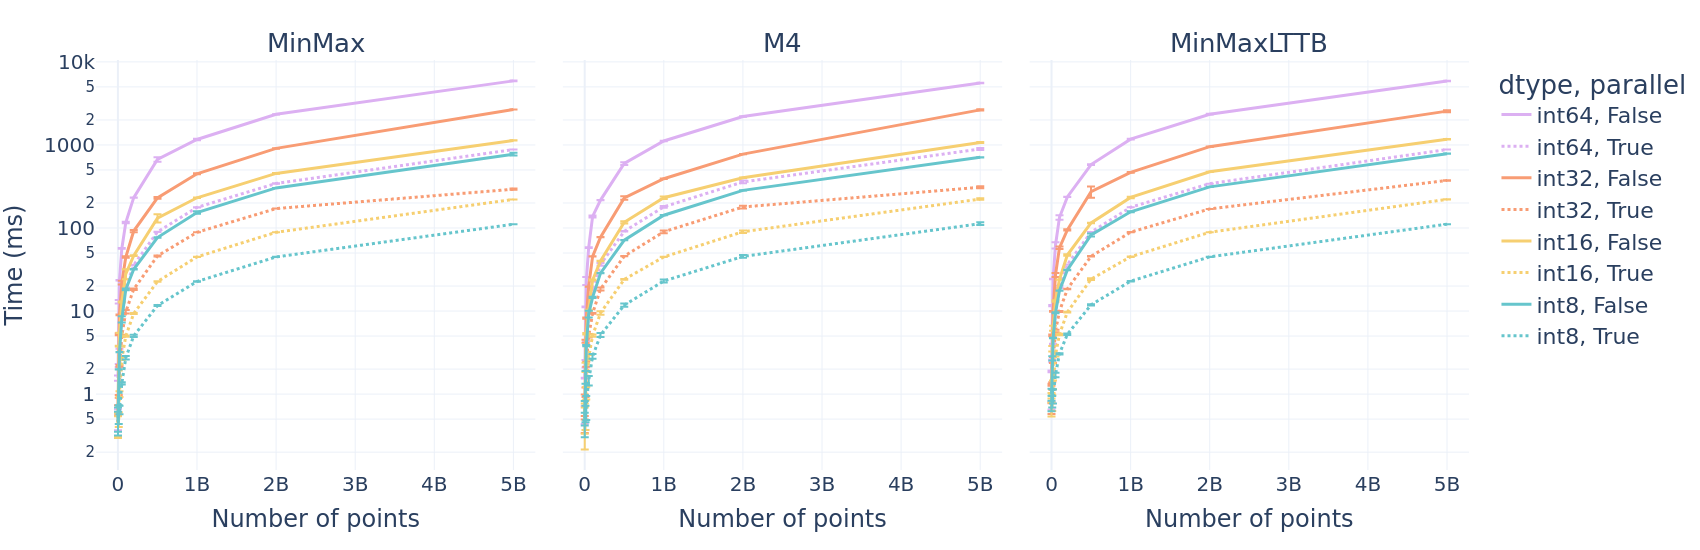

In [9]:
import plotly.express as px

algos_to_plot = [
    "MinMax",
    "M4",
    "MinMaxLTTB",
]

sub_df = df[df["algo_"].isin(algos_to_plot)].copy()
# clean the dtype column
sub_df["dtype"] = sub_df["dtype"].apply(
    lambda x: x.split(".")[-1].rstrip("'>")
)
sub_df = sub_df[sub_df["dtype"].str.startswith("int")]

sub_df["sort_key"] = sub_df["dtype"].str.replace("int", "").astype(int) * - 1
sub_df.sort_values(by=["sort_key", "N"], inplace=True)


fig = px.line(
    sub_df,
    x="N",
    y="mean",
    color="dtype",
    facet_col="algo_",
    # dash based on parallel
    line_dash="parallel",
    # facet_col="dtype",
    facet_col_wrap=3,
    error_y="std",
    # log_x=True,
    log_y=True,
    # title="Downsampling time (ms) vs. number of points",
    color_discrete_sequence=px.colors.qualitative.Pastel[:4][::-1],
)
fig.update_layout(
    template="plotly_white",
    height=550,
    width=1700,
    # update font size
    font=dict(
        size=20,
    ),
    # update legend font size
    legend=dict(
        font=dict(
            size=22,
        ),
    ),
)

# set the y-axis range
# fig.update_yaxes(range=[0.5, 3.55])
# set the x-axis range
# fig.update_xaxes(range=[-10_000_000, 2_150_000_000])

fig.update_xaxes(title_text="Number of points")
# only show the y-axis title for the first column
fig.update_yaxes(title_text="Time (ms)", row=1, col=1)
# update the subplot titles
for i, title in enumerate(algos_to_plot):
    fig.layout.annotations[i].text = title
    fig.layout.annotations[i].font.size = 26
    fig.layout.annotations[i].font.family = "Arial"
# Update the line width to 3
for i, trace in enumerate(fig.data):
    fig.data[i].line.width = 3

# update the legend order to inverse the order of the legend
fig.update_layout(
    legend=dict(
        traceorder="normal",
    ),
)

fig.show(renderer="png")

In [10]:
# fig.write_html("downsampling.html")

---

### Other plots

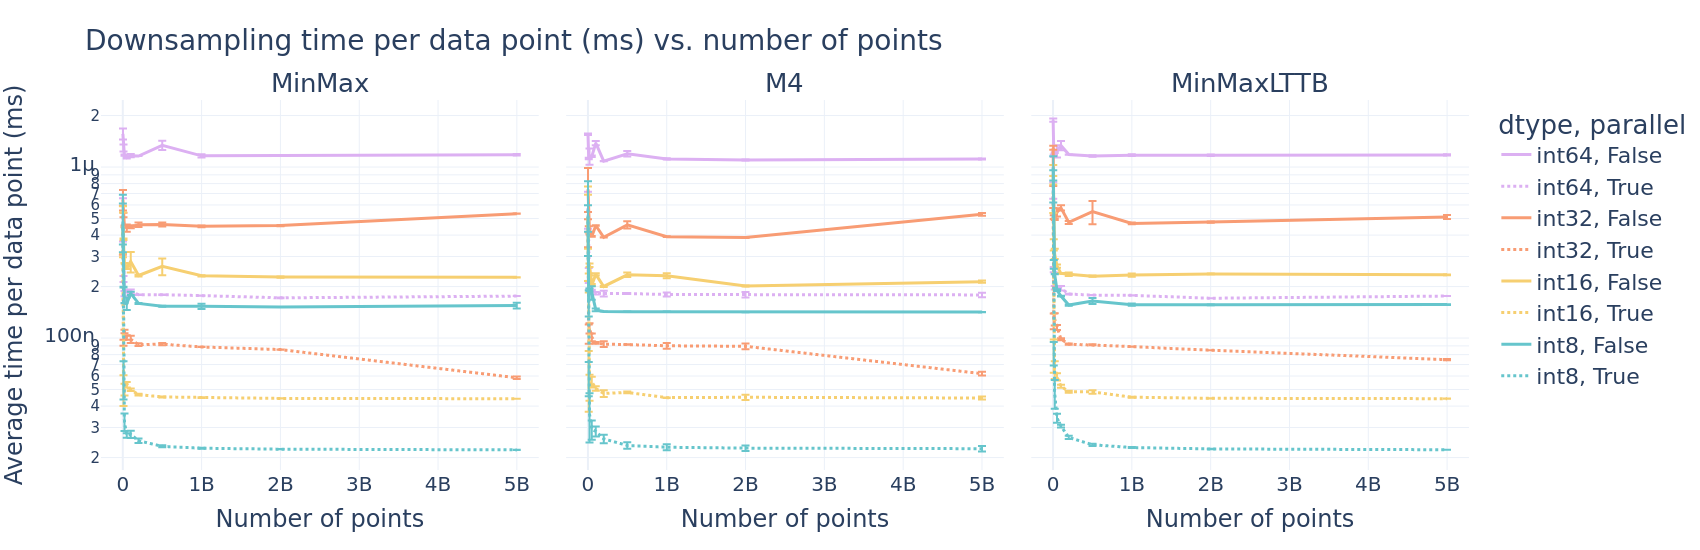

In [11]:
import plotly.express as px

algos_to_plot = [
    "MinMax",
    "M4",
    "MinMaxLTTB",
]

sub_df = df[df["algo_"].isin(algos_to_plot)].copy()
# clean the dtype column
sub_df["dtype"] = sub_df["dtype"].apply(
    lambda x: x.split(".")[-1].rstrip("'>")
)
sub_df = sub_df[sub_df["dtype"].str.startswith("int")]

sub_df["sort_key"] = sub_df["dtype"].str.replace("int", "").astype(int) * - 1
sub_df.sort_values(by=["sort_key", "N"], inplace=True)

sub_df["mean_N"] = sub_df["mean"] / sub_df["N"]
sub_df["std_N"] = sub_df["std"] / sub_df["N"]


fig = px.line(
    sub_df,
    x="N",
    y="mean_N",
    color="dtype",
    facet_col="algo_",
    # dash based on parallel
    line_dash="parallel",
    # facet_col="dtype",
    facet_col_wrap=3,
    error_y="std_N",
    # log_x=True,
    log_y=True,
    title="Downsampling time per data point (ms) vs. number of points",
    color_discrete_sequence=px.colors.qualitative.Pastel[:4][::-1],
)
fig.update_layout(
    template="plotly_white",
    height=550,
    width=1700,
    # update font size
    font=dict(
        size=20,
    ),
    # update legend font size
    legend=dict(
        font=dict(
            size=22,
        ),
    ),
)

fig.update_xaxes(title_text="Number of points")
# only show the y-axis title for the first column
fig.update_yaxes(title_text="Average time per data point (ms)", row=1, col=1)
# update the subplot titles
for i, title in enumerate(algos_to_plot):
    fig.layout.annotations[i].text = title
    fig.layout.annotations[i].font.size = 26
    fig.layout.annotations[i].font.family = "Arial"
# Update the line width to 3
for i, trace in enumerate(fig.data):
    fig.data[i].line.width = 3

# update the legend order to inverse the order of the legend
fig.update_layout(
    legend=dict(
        traceorder="normal",
    ),
)

fig.show(renderer="png")

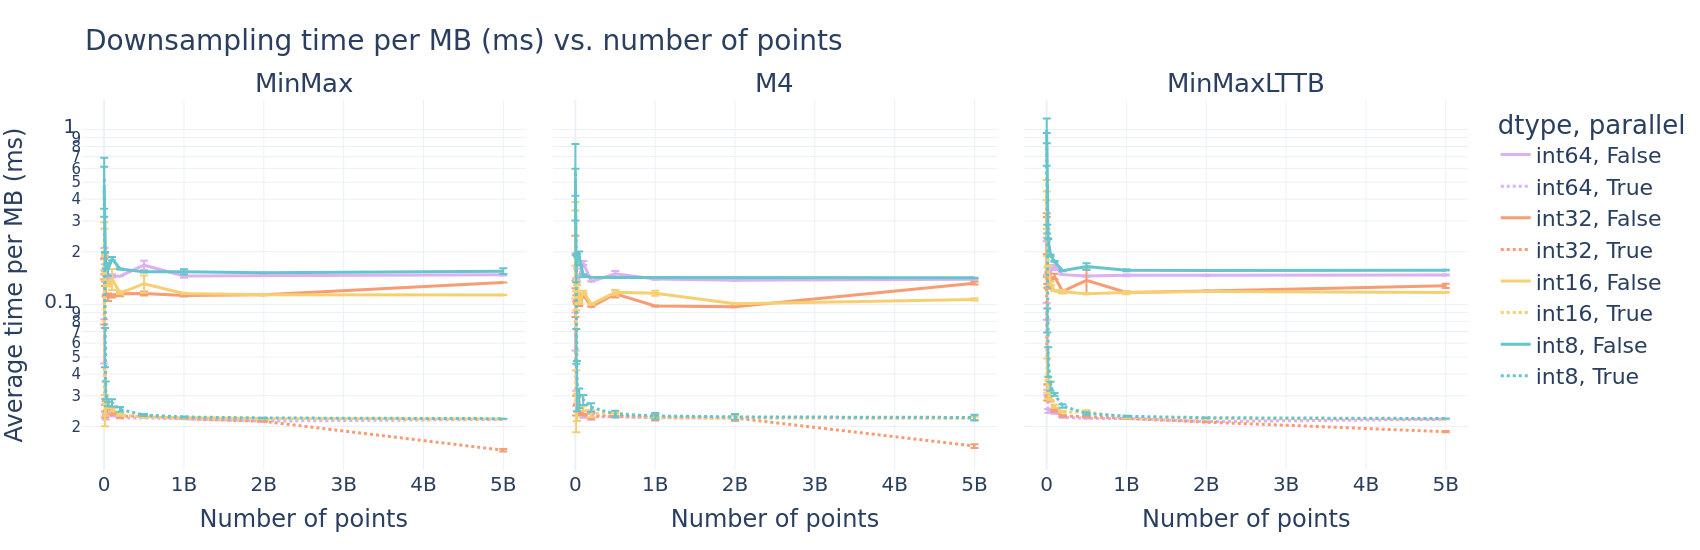

In [12]:
import plotly.express as px

algos_to_plot = [
    "MinMax",
    "M4",
    "MinMaxLTTB",
]

sub_df = df[df["algo_"].isin(algos_to_plot)].copy()
# clean the dtype column
sub_df["dtype"] = sub_df["dtype"].apply(
    lambda x: x.split(".")[-1].rstrip("'>")
)
sub_df = sub_df[sub_df["dtype"].str.startswith("int")]

sub_df["sort_key"] = sub_df["dtype"].str.replace("int", "").astype(int) * - 1
sub_df.sort_values(by=["sort_key", "N"], inplace=True)

sub_df["mean_MB"] = sub_df["mean"] / sub_df["MB"]
sub_df["std_MB"] = sub_df["std"] / sub_df["MB"]


fig = px.line(
    sub_df,
    x="N",
    y="mean_MB",
    color="dtype",
    facet_col="algo_",
    # dash based on parallel
    line_dash="parallel",
    # facet_col="dtype",
    facet_col_wrap=3,
    error_y="std_MB",
    # log_x=True,
    log_y=True,
    title="Downsampling time per MB (ms) vs. number of points",
    color_discrete_sequence=px.colors.qualitative.Pastel[:4][::-1],
)
fig.update_layout(
    template="plotly_white",
    height=550,
    width=1700,
    # update font size
    font=dict(
        size=20,
    ),
    # update legend font size
    legend=dict(
        font=dict(
            size=22,
        ),
    ),
)

fig.update_xaxes(title_text="Number of points")
# only show the y-axis title for the first column
fig.update_yaxes(title_text="Average time per MB (ms)", row=1, col=1)
# update the subplot titles
for i, title in enumerate(algos_to_plot):
    fig.layout.annotations[i].text = title
    fig.layout.annotations[i].font.size = 26
    fig.layout.annotations[i].font.family = "Arial"
# Update the line width to 3
for i, trace in enumerate(fig.data):
    fig.data[i].line.width = 3

# update the legend order to inverse the order of the legend
fig.update_layout(
    legend=dict(
        traceorder="normal",
    ),
)

fig.show(renderer="png")